In [1]:
import polars as pl
import fitter
from datetime import date 
import requests as rq
from distfit import distfit

# Getting Bitcoin Historical Index

In [2]:
# Get btc candlestick data from 2012 to 2021 from csv file

btc = pl.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv", infer_schema_length = 2000).select(
    pl.col("Timestamp"),pl.col("Open"),pl.col("High"),pl.col("Low"),pl.col("Close"),pl.col("Volume_(BTC)").alias("Volume")
).fill_nan(None).drop_nulls().with_columns(
    
    # Add return column
    Return = pl.col("Close") - pl.col("Open")
)
print(btc)

shape: (3_613_769, 7)
┌────────────┬──────────┬──────────┬──────────┬──────────┬───────────┬────────┐
│ Timestamp  ┆ Open     ┆ High     ┆ Low      ┆ Close    ┆ Volume    ┆ Return │
│ ---        ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---       ┆ ---    │
│ i64        ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64       ┆ f64    │
╞════════════╪══════════╪══════════╪══════════╪══════════╪═══════════╪════════╡
│ 1325317920 ┆ 4.39     ┆ 4.39     ┆ 4.39     ┆ 4.39     ┆ 0.455581  ┆ 0.0    │
│ 1325346600 ┆ 4.39     ┆ 4.39     ┆ 4.39     ┆ 4.39     ┆ 48.0      ┆ 0.0    │
│ 1325350740 ┆ 4.5      ┆ 4.57     ┆ 4.5      ┆ 4.57     ┆ 37.862297 ┆ 0.07   │
│ 1325350800 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 9.0       ┆ 0.0    │
│ 1325391360 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 1.502     ┆ 0.0    │
│ …          ┆ …        ┆ …        ┆ …        ┆ …        ┆ …         ┆ …      │
│ 1617148560 ┆ 58714.31 ┆ 58714.31 ┆ 58686.0  ┆ 58686.0  ┆ 1.384487  ┆ -28.31 │
│ 1617148620 ┆ 586

In [3]:
# Add in / concatenate data from 2021 - 2024 to the dataset
for p in range(1,8):
    path = "BAZAR_KHAFAJI_BTCUSD_FROM2021_"+str(p)+".csv"
    btc_temp = pl.read_csv(path, infer_schema_length = 2000000).select(
        pl.col("timestamp").alias("Timestamp"),
        pl.col("open").cast(pl.Float64).alias("Open"),
        pl.col("high").cast(pl.Float64).alias("High"),
        pl.col("low").cast(pl.Float64).alias("Low"),
        pl.col("close").cast(pl.Float64).alias("Close"),
        pl.col("volume").cast(pl.Float64).alias("Volume")
    ).with_columns(
        
        # Add return column
        Return = pl.col("Close") - pl.col("Open")
    )
    
    btc = pl.concat([btc,btc_temp]).sort("Timestamp")
print(btc)

shape: (5_216_489, 7)
┌────────────┬─────────┬─────────┬─────────┬─────────┬───────────┬────────┐
│ Timestamp  ┆ Open    ┆ High    ┆ Low     ┆ Close   ┆ Volume    ┆ Return │
│ ---        ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ ---       ┆ ---    │
│ i64        ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆ f64       ┆ f64    │
╞════════════╪═════════╪═════════╪═════════╪═════════╪═══════════╪════════╡
│ 1325317920 ┆ 4.39    ┆ 4.39    ┆ 4.39    ┆ 4.39    ┆ 0.455581  ┆ 0.0    │
│ 1325346600 ┆ 4.39    ┆ 4.39    ┆ 4.39    ┆ 4.39    ┆ 48.0      ┆ 0.0    │
│ 1325350740 ┆ 4.5     ┆ 4.57    ┆ 4.5     ┆ 4.57    ┆ 37.862297 ┆ 0.07   │
│ 1325350800 ┆ 4.58    ┆ 4.58    ┆ 4.58    ┆ 4.58    ┆ 9.0       ┆ 0.0    │
│ 1325391360 ┆ 4.58    ┆ 4.58    ┆ 4.58    ┆ 4.58    ┆ 1.502     ┆ 0.0    │
│ …          ┆ …       ┆ …       ┆ …       ┆ …       ┆ …         ┆ …      │
│ 1713282960 ┆ 62045.0 ┆ 62071.0 ┆ 62016.0 ┆ 62016.0 ┆ 0.041638  ┆ -29.0  │
│ 1713283020 ┆ 61977.0 ┆ 62004.0 ┆ 61873.0 ┆ 61873.0 ┆ 0.429763  ┆

In [ ]:
#download the dataset for possible use outside the program
btc.write_csv("BAZAR_KHAFAJI_BTCUSD_2012_2024.csv", separator=",")

# Fitting the return of the BTC return data

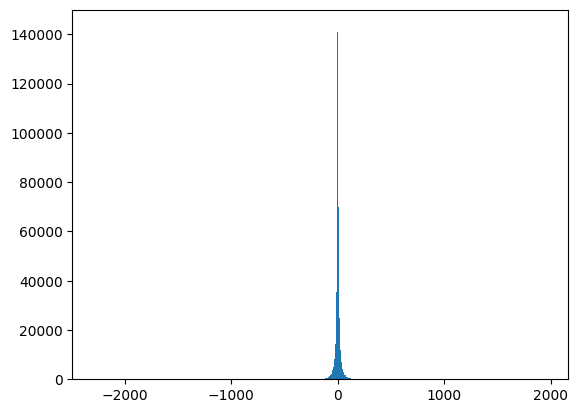

In [20]:
# show the histogram of the return data

import matplotlib.pyplot as plt

btc_return = btc.select("Return").to_numpy()

plt.hist(btc_return, bins=4000, label = "Bitcoin Return Histogram")
plt.ylim(top = 150000)
plt.show()


[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [alpha          ] [145. sec] [RSS: 0.12806] [loc=-1794.059 scale=111.835]
[distfit] >INFO> [anglit         ] [64.2 sec] [RSS: 0.125095] [loc=-27.675 scale=1814.233]
[distfit] >INFO> [arcsine        ] [108. sec] [RSS: 0.126014] [loc=-1567.110 scale=2964.330]
[distfit] >INFO> [beta           ] [225. sec] [RSS: 0.108036] [loc=-12241.165 scale=20910.422]
[distfit] >INFO> [betaprime      ] [261. sec] [RSS: 0.129534] [loc=-927.230 scale=3.658]
[distfit] >INFO> [bradford       ] [97.9 sec] [RSS: 0.125404] [loc=-1154.110 scale=2440.110]
[distfit] >INFO> [burr           ] [879. sec] [RSS: 0.118162] [loc=-2468.314 scale=2134.164]
[distfit] >INFO> [cauchy         ] [16.4 sec] [RSS: 0.0383527] [loc=0.014 scale=1.554]
[distfit] >INFO> [chi            ] [176. sec] [RSS: 0.125734] [loc=-68.000 scale=2.439]
[distfit] >INFO> [chi2           ] [198. sec] [RSS: 0.124371] [loc=-866.164 scale=58.858]
[distfit] >INFO> [cosine         ] [121. s

(<Figure size 2000x1000 with 1 Axes>,
 <Axes: title={'center': 'Gennorm (best fit)'}, xlabel='Probability Density Function (PDF)', ylabel='RSS (goodness of fit test)'>)

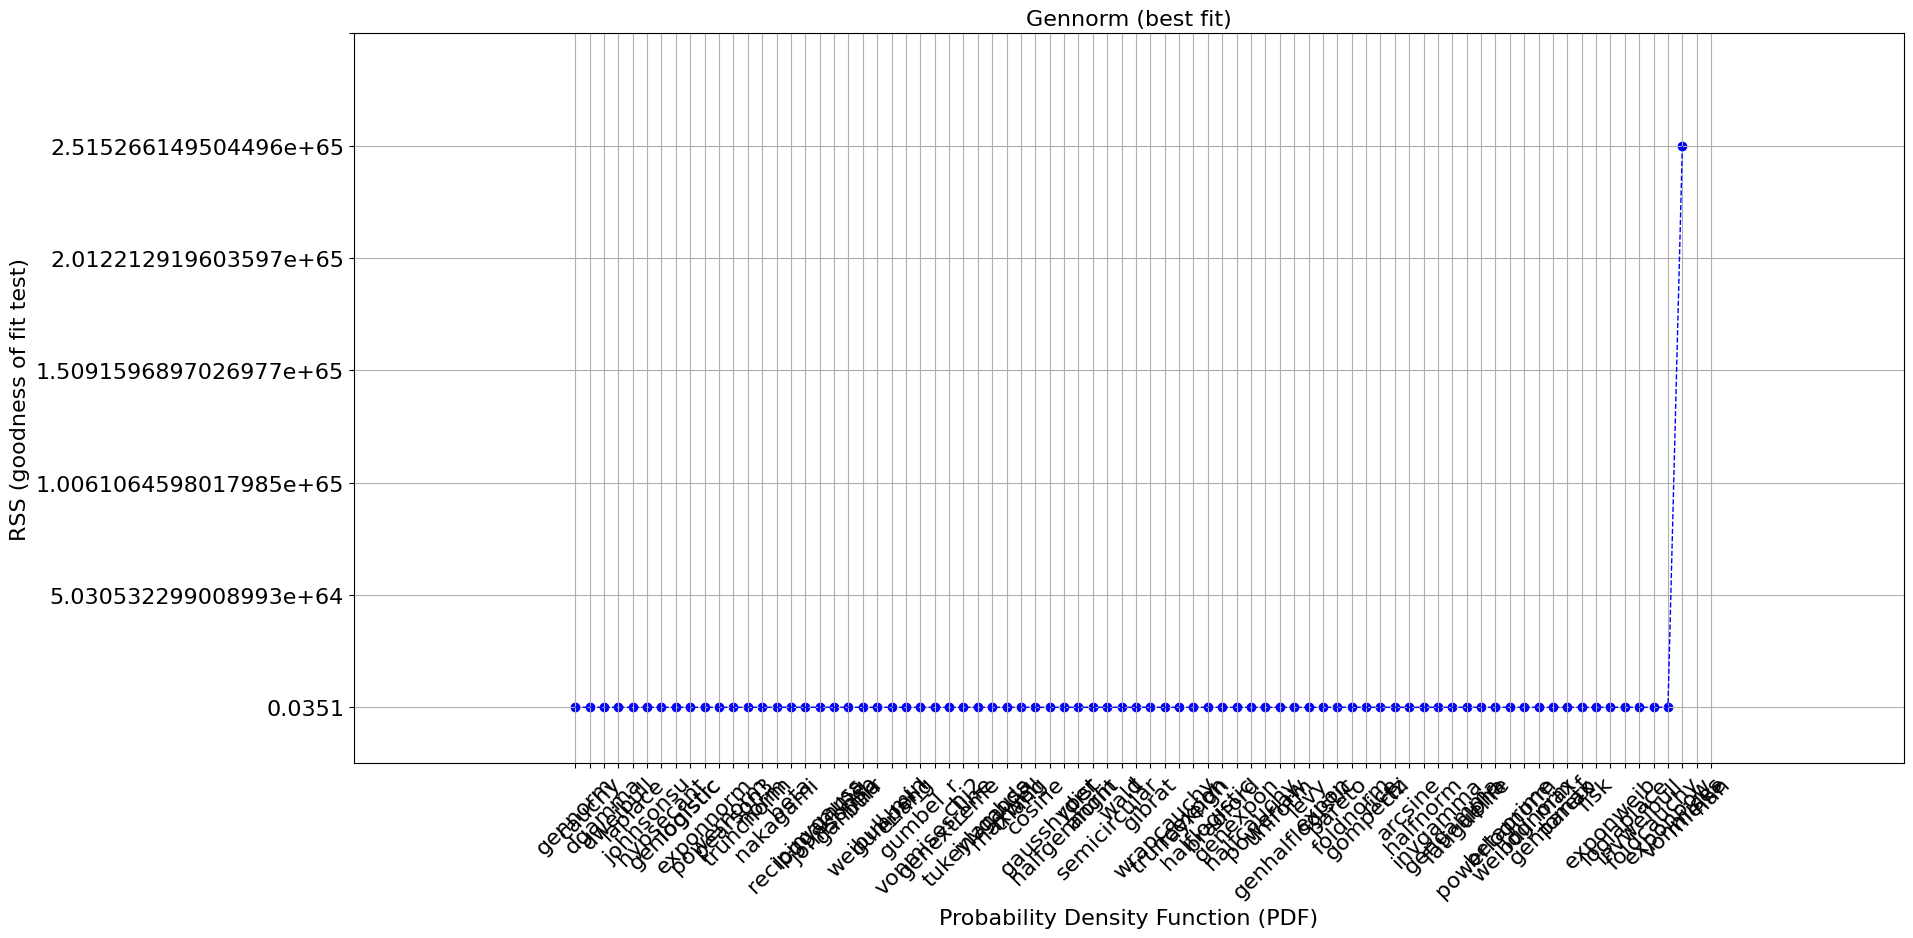

In [12]:
# use distfit module to get which probability distribution best fits the data
# Distfit module will give the Residual Sum of Square (RSS)
# RSS closer to 0 signifies that the distribution fits the data better.

dfit2 = distfit(distr = 'full', bins=4000)
dfit2.fit_transform(btc_return)
dfit2.plot_summary()

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [gennorm ] [236. sec] [RSS: 0.0351114] [loc=0.000 scale=0.002]
[distfit] >INFO> [cauchy  ] [20.7 sec] [RSS: 0.0383527] [loc=0.014 scale=1.554]
[distfit] >INFO> [dgamma  ] [172. sec] [RSS: 0.050533] [loc=-0.000 scale=19.984]
[distfit] >INFO> [dweibull] [289. sec] [RSS: 0.0575672] [loc=0.000 scale=9.060]
[distfit] >INFO> [laplace ] [0.14 sec] [RSS: 0.0821364] [loc=0.000 scale=8.842]
[distfit] >INFO> [norm    ] [0.10 sec] [RSS: 0.108006] [loc=0.031 scale=22.781]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Ploting Summary.


(<Figure size 2000x1000 with 1 Axes>,
 <Axes: title={'center': 'Gennorm (best fit)'}, xlabel='Probability Density Function (PDF)', ylabel='RSS (goodness of fit test)'>)

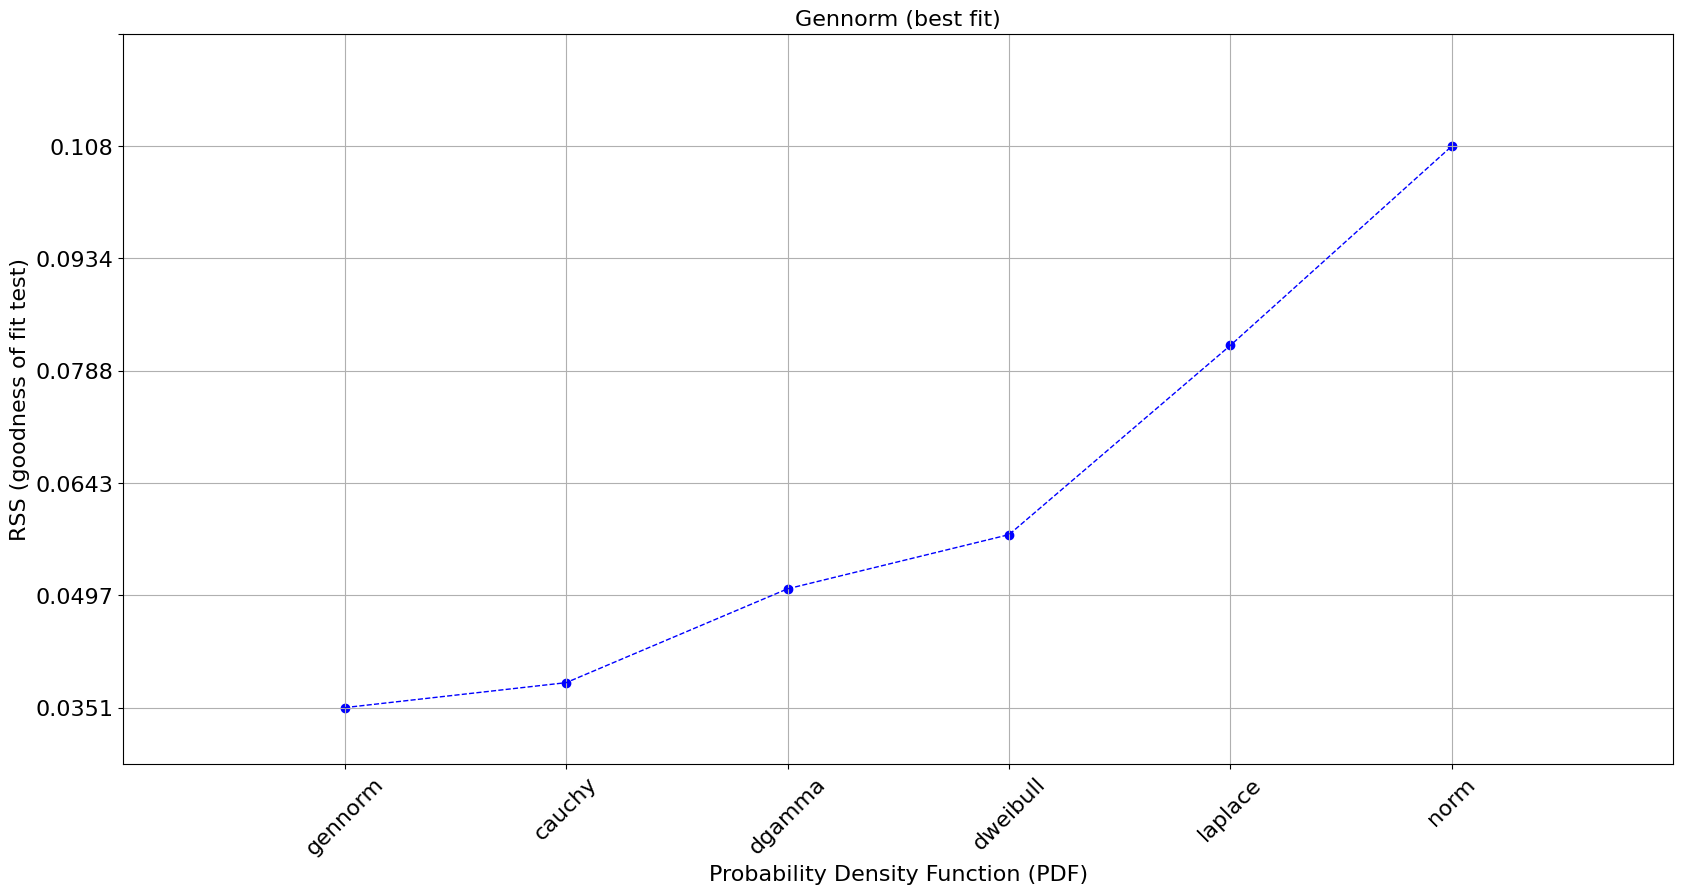

In [21]:
# use distfit module to get which probability distribution best fits the data
# Distfit module will give the Residual Sum of Square (RSS)
# RSS closer to 0 signifies that the distribution fits the data better.

# This uses the top 5 best fitting distributions above, and the normal distribution,
# so that the RSS plot could be looked at better
dfit = distfit(distr = ['gennorm',
                        'cauchy',
                        'dgamma',
                        'dweibull',
                        'laplace',
                        'norm'] ,bins=4000)
dfit.fit_transform(btc_return)
dfit.plot_summary()

The best distribution that fit the BTCUSD return data is the Generalized Normal probability distribution

# Getting ETH historical index

In [ ]:
# Create empty dataframe
eth = pl.DataFrame()

#Read and concatenate ETH candlestick data
for p in range(1,5):
    path = "BAZAR_KHAFAJI_ETHUSD_"+str(p)+".csv"
    eth_sub = pl.read_csv(path)
    eth = pl.concat([eth,eth_sub]).with_columns(
        
        # Add return column
        Return = pl.col("close") - pl.col("open")
    )

#print table
print(eth)

In [ ]:
# Save ETHUSD data for use outside of the program
eth.write_csv("BAZAR_KHAFAJI_ETHUSD_AUG2017_APR2024.csv", separator=",")